In [1]:
#pip install pandas

In [2]:
#pip install mne matplotlib

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                         
import matplotlib.patches as patches
import scipy.signal as signal
from scipy.signal import butter, sosfiltfilt, sosfreqz  
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import mne
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
df = pd.read_csv('ERPdata.csv')
df.head()

,subject,condition,Fz,FCz,Cz,FC3,FC4,C3,C4,CP3,CP4,time_ms
0,1,1,5.533701,5.726507,5.469535,5.386723,4.588875,6.560092,4.542811,5.397492,5.103695,-1500.0000
1,1,1,5.651489,5.837326,5.773131,5.627975,4.822217,6.739976,4.811770,5.541357,5.379273,-1499.0234
2,1,1,5.717580,5.932924,5.948466,5.826460,4.979647,7.026199,5.053779,5.634972,5.600504,-1498.0469
3,1,1,5.703267,5.968103,5.851512,5.812192,4.992899,6.940671,5.106650,5.543577,5.589775,-1497.0703
4,1,1,5.571578,5.917541,5.812808,5.744715,4.963338,6.726491,5.158073,5.454069,5.614092,-1496.0938


## ERP Dataset Visualization

In [5]:
df['condition']

0         1
1         1
2         1
3         1
4         1
         ..
746491    3
746492    3
746493    3
746494    3
746495    3
Name: condition, Length: 746496, dtype: int64

In [6]:
dem = pd.read_csv('demographic.csv')
dem.head()

,subject,group,gender,age,education
0,1,0,M,44,16.0
1,2,0,M,39,17.0
2,3,0,M,53,18.0
3,4,0,M,52,15.0
4,5,0,M,41,16.0


In [7]:
ERP = df[df['condition']==1]

## Replicate plots

In [8]:
ERP = df.merge(dem, on='subject')
ERP

,subject,condition,Fz,FCz,Cz,FC3,FC4,C3,C4,CP3,CP4,time_ms,group,gender,age,education
0,1,1,5.533701,5.726507,5.469535,5.386723,4.588875,6.560092,4.542811,5.397492,5.103695,-1500.0000,0,M,44,16.0
1,1,1,5.651489,5.837326,5.773131,5.627975,4.822217,6.739976,4.811770,5.541357,5.379273,-1499.0234,0,M,44,16.0
2,1,1,5.717580,5.932924,5.948466,5.826460,4.979647,7.026199,5.053779,5.634972,5.600504,-1498.0469,0,M,44,16.0
3,1,1,5.703267,5.968103,5.851512,5.812192,4.992899,6.940671,5.106650,5.543577,5.589775,-1497.0703,0,M,44,16.0
4,1,1,5.571578,5.917541,5.812808,5.744715,4.963338,6.726491,5.158073,5.454069,5.614092,-1496.0938,0,M,44,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746491,81,3,-0.401267,0.041014,-0.352556,0.712530,-0.427019,0.479170,1.041864,0.645761,-0.085649,1495.1172,1,M,56,13.0
746492,81,3,-0.440294,0.093863,-0.422151,0.792209,-0.469230,0.486767,0.955658,0.601938,-0.264824,1496.0938,1,M,56,13.0
746493,81,3,-0.466162,0.083799,-0.485091,0.799034,-0.466002,0.516740,0.972635,0.612470,-0.463196,1497.0703,1,M,56,13.0
746494,81,3,-0.472620,0.003017,-0.465663,0.675452,-0.408777,0.558901,0.943028,0.635287,-0.656748,1498.0469,1,M,56,13.0


In [9]:
ERP = ERP.iloc[:, 0:-3]
ERP = ERP.drop(['FC3','FC4','C3','C4', 'CP3', 'CP4'], axis=1)
ERP[' group'] = ERP[' group'].apply(lambda x: 'HC' if x==0 else 'SZ')

In [10]:
ERP = ERP[(ERP.time_ms >= -100) & (ERP.time_ms <= 300)].groupby([' group', 'condition','time_ms']).mean()

In [11]:
ERP

subject        Fz       FCz        Cz
 group condition time_ms                                          
HC     1         -99.6094   25.00000  0.455273  0.431357  0.139358
                 -98.6328   25.00000  0.435204  0.423137  0.108364
                 -97.6563   25.00000  0.466328  0.454093  0.132008
                 -96.6797   25.00000  0.466787  0.438854  0.150605
                 -95.7031   25.00000  0.456643  0.423483  0.142539
...                              ...       ...       ...       ...
SZ     3          295.8984  51.44898  1.297023  1.562212  1.799549
                  296.8750  51.44898  1.279030  1.527202  1.771924
                  297.8516  51.44898  1.314048  1.552417  1.773222
                  298.8281  51.44898  1.340739  1.563762  1.774739
                  299.8047  51.44898  1.248507  1.468130  1.693612

[2460 rows x 4 columns]

In [12]:
display(ERP[:3])

subject        Fz       FCz        Cz
 group condition time_ms                                        
HC     1         -99.6094     25.0  0.455273  0.431357  0.139358
                 -98.6328     25.0  0.435204  0.423137  0.108364
                 -97.6563     25.0  0.466328  0.454093  0.132008

In [13]:
## prepare data 
ERP.loc[(slice(None),1), ['Fz', 'FCz', 'Cz']] = ERP.loc[(slice(None),1), ['Fz', 'FCz', 'Cz']] - ERP.loc[(slice(None),3), ['Fz', 'FCz', 'Cz']].values
ERP = ERP.drop(index=3, level=1)
ERP.reset_index()
display(ERP[:3])

subject        Fz       FCz        Cz
 group condition time_ms                                        
HC     1         -99.6094     25.0 -0.106914 -0.161320 -0.120676
                 -98.6328     25.0 -0.135403 -0.165145 -0.168089
                 -97.6563     25.0 -0.083589 -0.105603 -0.120451

In [14]:
ERP=ERP.reset_index()
ERP = pd.melt(ERP, id_vars=[' group', 'condition', 'time_ms'], value_vars=['Fz', 'FCz', 'Cz'])
ERP

,group,condition,time_ms,variable,value
0,HC,1,-99.6094,Fz,-0.106914
1,HC,1,-98.6328,Fz,-0.135403
2,HC,1,-97.6563,Fz,-0.083589
3,HC,1,-96.6797,Fz,-0.056245
4,HC,1,-95.7031,Fz,-0.012324
...,...,...,...,...,...
4915,SZ,2,295.8984,Cz,0.003643
4916,SZ,2,296.8750,Cz,-0.008686
4917,SZ,2,297.8516,Cz,0.032826
4918,SZ,2,298.8281,Cz,0.012877


In [15]:
ERP['condition'] = ERP['condition'].apply(lambda x: 'playtone' if x==2 else 'buttontone')
ERP

,group,condition,time_ms,variable,value
0,HC,buttontone,-99.6094,Fz,-0.106914
1,HC,buttontone,-98.6328,Fz,-0.135403
2,HC,buttontone,-97.6563,Fz,-0.083589
3,HC,buttontone,-96.6797,Fz,-0.056245
4,HC,buttontone,-95.7031,Fz,-0.012324
...,...,...,...,...,...
4915,SZ,playtone,295.8984,Cz,0.003643
4916,SZ,playtone,296.8750,Cz,-0.008686
4917,SZ,playtone,297.8516,Cz,0.032826
4918,SZ,playtone,298.8281,Cz,0.012877


In [16]:
## plot of several conditions
button = ERP[ERP['condition'] == 'buttontone']
play = ERP[ERP['condition'] == 'playtone']
button

,group,condition,time_ms,variable,value
0,HC,buttontone,-99.6094,Fz,-0.106914
1,HC,buttontone,-98.6328,Fz,-0.135403
2,HC,buttontone,-97.6563,Fz,-0.083589
3,HC,buttontone,-96.6797,Fz,-0.056245
4,HC,buttontone,-95.7031,Fz,-0.012324
...,...,...,...,...,...
4505,SZ,buttontone,295.8984,Cz,-0.171759
4506,SZ,buttontone,296.8750,Cz,-0.166959
4507,SZ,buttontone,297.8516,Cz,-0.221777
4508,SZ,buttontone,298.8281,Cz,-0.225479


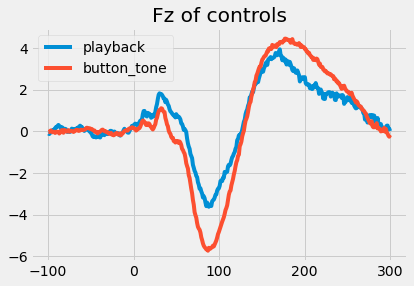

In [17]:
# plot of HC in buttonetone vs playback in different channels
plt.style.use('fivethirtyeight')
x1 = button.loc[(button['variable'] == 'Fz') & (button[' group'] == 'HC'), ['time_ms','value']]
y1 = play.loc[(play['variable'] == 'Fz') & (play[' group'] == 'HC'), ['time_ms','value']]

plt.figure()
plt.plot(x1['time_ms'], x1['value'])
plt.plot(y1['time_ms'], y1['value'])
plt.title('Fz of controls')
plt.legend(['playback','button_tone'])

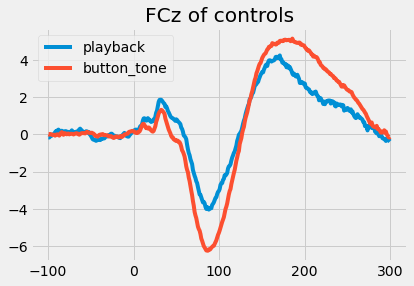

In [18]:
x2 = button.loc[(button['variable'] == 'FCz') & (button[' group'] == 'HC'), ['time_ms','value']]
y2 = play.loc[(play['variable'] == 'FCz') & (play[' group'] == 'HC'), ['time_ms','value']]

plt.figure()
plt.plot(x2['time_ms'], x2['value'])
plt.plot(y2['time_ms'], y2['value'])
plt.title('FCz of controls')
plt.legend(['playback','button_tone'])

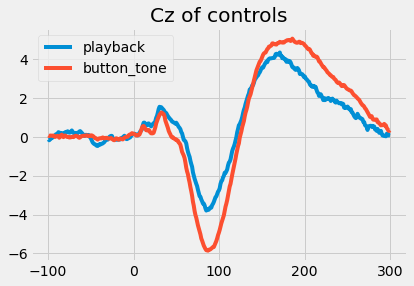

In [19]:
x3 = button.loc[(button['variable'] == 'Cz') & (button[' group'] == 'HC'), ['time_ms','value']]
y3 = play.loc[(play['variable'] == 'Cz') & (play[' group'] == 'HC'), ['time_ms','value']]

plt.figure()
plt.plot(x3['time_ms'], x3['value'])
plt.plot(y3['time_ms'], y3['value'])
plt.title('Cz of controls')
plt.legend(['playback','button_tone'])

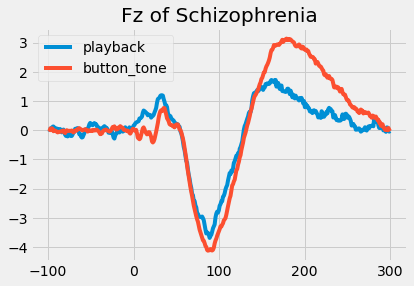

In [20]:
# plot of SZ in buttonetone vs playback in different channels
x4 = button.loc[(button['variable'] == 'Fz') & (button[' group'] == 'SZ'), ['time_ms','value']]
y4 = play.loc[(play['variable'] == 'Fz') & (play[' group'] == 'SZ'), ['time_ms','value']]

plt.figure()
plt.plot(x4['time_ms'], x4['value'])
plt.plot(y4['time_ms'], y4['value'])
plt.title('Fz of Schizophrenia')
plt.legend(['playback','button_tone'])

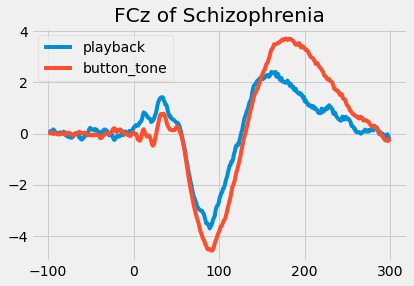

In [21]:
x5 = button.loc[(button['variable'] == 'FCz') & (button[' group'] == 'SZ'), ['time_ms','value']]
y5 = play.loc[(play['variable'] == 'FCz') & (play[' group'] == 'SZ'), ['time_ms','value']]

plt.figure()
plt.plot(x5['time_ms'], x5['value'])
plt.plot(y5['time_ms'], y5['value'])
plt.title('FCz of Schizophrenia')
plt.legend(['playback','button_tone'])

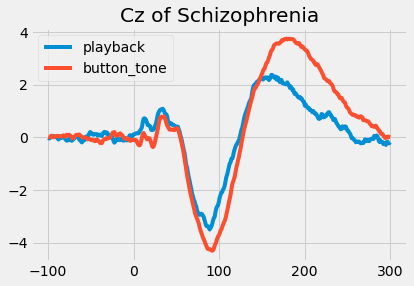

In [22]:
x6 = button.loc[(button['variable'] == 'Cz') & (button[' group'] == 'SZ'), ['time_ms','value']]
y6 = play.loc[(play['variable'] == 'Cz') & (play[' group'] == 'SZ'), ['time_ms','value']]

plt.figure()
plt.plot(x6['time_ms'], x6['value'])
plt.plot(y6['time_ms'], y6['value'])
plt.title('Cz of Schizophrenia')
plt.legend(['playback','button_tone'])

### Plot Scalp Topography 

In [23]:
#Topography for Healthy group
HC = ERP[ERP[' group'] == 'HC']
HC

,group,condition,time_ms,variable,value
0,HC,buttontone,-99.6094,Fz,-0.106914
1,HC,buttontone,-98.6328,Fz,-0.135403
2,HC,buttontone,-97.6563,Fz,-0.083589
3,HC,buttontone,-96.6797,Fz,-0.056245
4,HC,buttontone,-95.7031,Fz,-0.012324
...,...,...,...,...,...
4095,HC,playtone,295.8984,Cz,0.464255
4096,HC,playtone,296.8750,Cz,0.406632
4097,HC,playtone,297.8516,Cz,0.328958
4098,HC,playtone,298.8281,Cz,0.314174


In [24]:
HC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2460 entries, 0 to 4099
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0    group     2460 non-null   object 
 1   condition  2460 non-null   object 
 2   time_ms    2460 non-null   float64
 3   variable   2460 non-null   object 
 4   value      2460 non-null   float64
dtypes: float64(2), object(3)
memory usage: 115.3+ KB


In [25]:
HC

,group,condition,time_ms,variable,value
0,HC,buttontone,-99.6094,Fz,-0.106914
1,HC,buttontone,-98.6328,Fz,-0.135403
2,HC,buttontone,-97.6563,Fz,-0.083589
3,HC,buttontone,-96.6797,Fz,-0.056245
4,HC,buttontone,-95.7031,Fz,-0.012324
...,...,...,...,...,...
4095,HC,playtone,295.8984,Cz,0.464255
4096,HC,playtone,296.8750,Cz,0.406632
4097,HC,playtone,297.8516,Cz,0.328958
4098,HC,playtone,298.8281,Cz,0.314174


In [26]:
merged_df = pd.merge(
    HC[(HC.time_ms.between(80,100)) & (HC.condition=='buttontone')],
    HC[(HC.time_ms.between(80,100)) & (HC.condition=='playtone')],
    on=[' group', 'time_ms', 'variable'],
    suffixes=('_buttontone', '_playtone')
)

merged_df['value'] = merged_df['value_buttontone'] - merged_df['value_playtone']
merged_df

,group,condition_buttontone,time_ms,variable,value_buttontone,condition_playtone,value_playtone,value
0,HC,buttontone,80.0781,Fz,-2.993968,playtone,-5.223857,2.229889
1,HC,buttontone,81.0547,Fz,-3.180872,playtone,-5.387342,2.206470
2,HC,buttontone,82.0313,Fz,-3.121761,playtone,-5.496822,2.375061
3,HC,buttontone,83.0078,Fz,-3.215377,playtone,-5.563219,2.347842
4,HC,buttontone,83.9844,Fz,-3.422392,playtone,-5.607130,2.184738
...,...,...,...,...,...,...,...,...
58,HC,buttontone,95.7031,Cz,-3.105704,playtone,-5.459947,2.354243
59,HC,buttontone,96.6797,Cz,-3.060376,playtone,-5.363770,2.303395
60,HC,buttontone,97.6563,Cz,-2.941974,playtone,-5.228327,2.286353
61,HC,buttontone,98.6328,Cz,-2.822367,playtone,-5.066122,2.243755


In [27]:
g = merged_df.groupby("time_ms")
time_value = g.apply(lambda r: list(r.value))
subset = g.apply(lambda r: list(r.variable)).iloc[0]
print(subset)

biosemi_montage = mne.channels.make_standard_montage('biosemi64')
info = mne.create_info(subset, sfreq=1000., ch_types='eeg')

earr = mne.EvokedArray(
    np.array(time_value.tolist()).T,
    info
)
earr.set_montage(biosemi_montage)

['Fz', 'FCz', 'Cz']


<Evoked | '' (average, N=1), 0 – 0.02 sec, baseline off, 3 ch, ~11 kB>

In [28]:
subset

['Fz', 'FCz', 'Cz']

In [29]:
earr

<Evoked | '' (average, N=1), 0 – 0.02 sec, baseline off, 3 ch, ~11 kB>

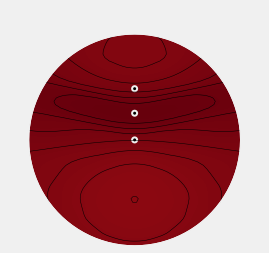

In [30]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)


earr.plot_sensors(axes=ax,show=False)
mne.viz.plot_topomap(np.mean(earr.data, axis=1),earr.info,show=False,axes=ax)
plt.show()

In [31]:
## For Schizophrenia group
SZ = ERP[ERP[' group'] == 'SZ']

In [32]:
SZ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2460 entries, 820 to 4919
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0    group     2460 non-null   object 
 1   condition  2460 non-null   object 
 2   time_ms    2460 non-null   float64
 3   variable   2460 non-null   object 
 4   value      2460 non-null   float64
dtypes: float64(2), object(3)
memory usage: 115.3+ KB


In [33]:
SZ

,group,condition,time_ms,variable,value
820,SZ,buttontone,-99.6094,Fz,0.033591
821,SZ,buttontone,-98.6328,Fz,0.020566
822,SZ,buttontone,-97.6563,Fz,0.040279
823,SZ,buttontone,-96.6797,Fz,0.062540
824,SZ,buttontone,-95.7031,Fz,0.071409
...,...,...,...,...,...
4915,SZ,playtone,295.8984,Cz,0.003643
4916,SZ,playtone,296.8750,Cz,-0.008686
4917,SZ,playtone,297.8516,Cz,0.032826
4918,SZ,playtone,298.8281,Cz,0.012877


In [34]:
merged_df = pd.merge(
    SZ[(SZ.time_ms.between(80,100)) & (SZ.condition=='buttontone')],
    SZ[(SZ.time_ms.between(80,100)) & (SZ.condition=='playtone')],
    on=[' group', 'time_ms', 'variable'],
    suffixes=('_buttontone', '_playtone')
)

merged_df['value'] = merged_df['value_buttontone'] - merged_df['value_playtone']
merged_df

,group,condition_buttontone,time_ms,variable,value_buttontone,condition_playtone,value_playtone,value
0,SZ,buttontone,80.0781,Fz,-2.954230,playtone,-3.686901,0.732671
1,SZ,buttontone,81.0547,Fz,-3.010002,playtone,-3.769482,0.759480
2,SZ,buttontone,82.0313,Fz,-3.084806,playtone,-3.783958,0.699152
3,SZ,buttontone,83.0078,Fz,-3.245439,playtone,-3.865382,0.619943
4,SZ,buttontone,83.9844,Fz,-3.403181,playtone,-3.964036,0.560856
...,...,...,...,...,...,...,...,...
58,SZ,buttontone,95.7031,Cz,-2.826234,playtone,-4.028085,1.201852
59,SZ,buttontone,96.6797,Cz,-2.689376,playtone,-3.955305,1.265928
60,SZ,buttontone,97.6563,Cz,-2.619291,playtone,-3.848882,1.229591
61,SZ,buttontone,98.6328,Cz,-2.576625,playtone,-3.766657,1.190032


In [35]:
g1 = merged_df.groupby("time_ms")
time_value = g1.apply(lambda r: list(r.value))
subset = g1.apply(lambda r: list(r.variable)).iloc[0]
print(subset)

biosemi_montage = mne.channels.make_standard_montage('biosemi64')
info = mne.create_info(subset, sfreq=1000., ch_types='eeg')

earr = mne.EvokedArray(
    np.array(time_value.tolist()).T,
    info
)
print(earr)
earr.set_montage(biosemi_montage)

['Fz', 'FCz', 'Cz']
<Evoked | '' (average, N=1), 0 – 0.02 sec, baseline off, 3 ch, ~9 kB>


<Evoked | '' (average, N=1), 0 – 0.02 sec, baseline off, 3 ch, ~11 kB>

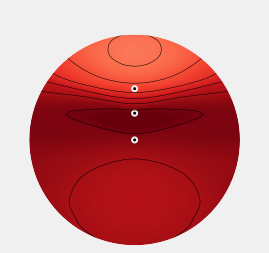

In [36]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)


earr.plot_sensors(axes=ax,show=False)
mne.viz.plot_topomap(np.mean(earr.data, axis=1),earr.info,show=False,axes=ax)
plt.show()

## Classification

### Define Epoch, ERP Windows

In [37]:
fs = 1024 # Hz
epoch_start = -1500  # ms
epoch_end = 1500     # ms
erp_s = 50
erp_e = 250

# ERP window
s = np.round((erp_s - epoch_start) * (fs / 1000)).astype(int)
e = np.round((erp_e - epoch_start) * (fs / 1000)).astype(int)


# channel labels
cols = list(pd.read_csv('columnLabels.csv'))
channels = cols[4:]

In [38]:
df_9 = pd.read_csv('cleaned.csv')

In [39]:
train = df_9[(df_9['group']=='train')]
test = df_9[(df_9['group']=='test')]

In [40]:
test.iloc[:,0]

4952       0
4953       1
4954       2
4955       3
4956       4
        ... 
7435    2483
7436    2484
7437    2485
7438    2486
7439    2487
Name: Unnamed: 0, Length: 2488, dtype: int64

In [41]:
X_train = train.iloc[:, 1:-2]
Y_train = train.iloc[:, -2]

print(X_train.shape)
print(Y_train.shape)

(4952, 72)
(4952,)


In [42]:
X_test = test.iloc[:, 1:-2]
Y_test = test.iloc[:, -2]

print(X_test.shape)
print(Y_test.shape)

(2488, 72)
(2488,)


In [43]:
## LightGBM classifier

In [48]:

lgb_classifier = LGBMClassifier(objective='binary', random_state=5)

score = cross_val_score(lgb_classifier, X_train, Y_train, cv = 10)


In [91]:
# lgb classifier cv score
train_pred = lgb_fit.predict(X_train)

print(score)
print("LGB Classifier cv score: %f" %np.mean(score))
print("LGB Classifier accuracy score: %f" %accuracy_score(Y_train,train_pred))
print("LGB Classifier train AUC: %f" %roc_auc_score(Y_train, train_pred))

[0.78427419 0.78024194 0.82424242 0.78181818 0.79393939 0.77373737
 0.8        0.70505051 0.57777778 0.68686869]
LGB Classifier cv score: 0.750795
LGB Classifier accuracy score: 1.000000
LGB Classifier train AUC: 1.000000


In [92]:
lgb_fit = lgb_classifier.fit(X_train, Y_train)
test_pred = lgb_fit.predict(X_test)
test_acc = accuracy_score(Y_test,test_pred)

print("LGB Classifier test accuracy: %f" %test_acc)
print("LGB Classifier test AUC: %f" %roc_auc_score(Y_test, test_pred))

LGB Classifier test accuracy: 0.719051
LGB Classifier test AUC: 0.669772


In [51]:
## XG boost classifier


In [60]:
xgb_classifier = XGBClassifier()

xgb_score = cross_val_score(xgb_classifier, X_train, Y_train, cv = 10)

C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:51:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:51:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:51:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:51:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:51:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:51:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:51:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:51:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:52:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:52:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [86]:
# xgb classifier cv score

train_pred = xgb_fit.predict(X_train)
print(xgb_score)
print("XGBoost Classifier cv score: %f" %np.mean(xgb_score))
print("XGBoost Classifier accuracy score: %f" %accuracy_score(Y_train,train_pred))
print("XGBoost Classifier test AUC: %f" %roc_auc_score(Y_train, train_pred))

[0.7641129  0.75806452 0.81616162 0.77171717 0.72727273 0.72929293
 0.7979798  0.70707071 0.58989899 0.68080808]
XGBoost Classifier cv score: 0.734238
XGBoost Classifier accuracy score: 1.000000
XGBoost Classifier test AUC: 1.000000


1.0

In [76]:
xgb_fit = xgb_classifier.fit(X_train, Y_train)
test_pred = xgb_fit.predict(X_test)
test_acc = accuracy_score(Y_test,test_pred)

print("XGBoost Classifier test accuracy: %f" %test_acc)
print("XGBoost Classifier test AUC: %f" %roc_auc_score(Y_test,test_pred))

C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Jessica\miniconda3\envs\cogs189\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[16:29:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Classifier test accuracy: 0.718650
XGBoost Classifier test AUC: 0.672657
